# Objetivo
Queremos identificar perfis de alunos com padrões semelhantes de engajamento, desempenho, comportamento emocional.


# Bibliotecas e outros



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import dendrogram, linkage


CSV_FILE = "./relatorio.csv"

In [32]:
def read_data():
  df = pd.read_csv(CSV_FILE)

  df = df[(df['%_cumprida'] >= 0) & (df['%_cumprida'] <= 100)]

  return df

# Leitura, seleção e limpeza dos dados

In [33]:
df = read_data().copy()

numeric_selected_columns = ['%_cumprida', 'metas_realizadas', 'qtd_emocoes_positivas', 'qtd_emocoes_negativas', 'duracao_aula']
list_selected_column = 'emocional_aluno'
text_selected_column = 'dificuldades_encontradas'
feedback_selected_column = 'feedback_aula'

for col in numeric_selected_columns:
    df[col] = df[col].fillna(0)

df[list_selected_column] = df[list_selected_column].fillna('[]')

df[text_selected_column] = df[text_selected_column].fillna('')
df[feedback_selected_column] = df[feedback_selected_column].fillna('Não Informado')

df.head()

,Created Date,data_aula,nome_mentor,emocional_aluno,nome_aluno_bubble,conteudo_ministrado,materias_alunos,feedback_aula,dificuldades_encontradas,duracao_aula,...,hora_cadastrada_y,id_unico_metas,mes,ano,metas_realizadas,qtd_emocoes_positivas,qtd_emocoes_negativas,resultado_subtracao_emocoes,total_emocoes_modulo,listagem_valores_emocoes
0,2025-04-09 21:43:52.152000+00:00,04/04/2025,Rui Manuel Morais de Deus,['Ativo(a)'],tiago lustosa costa,Metamática - correção do simulado e questão de...,['Matemática'],Não Informado,"Seu desempenho atual nas mentorias está bom, e...",1.5,...,4.0,1738794256147x929996750296586200_14,Abril,2025,8.91,2,0,2,2,[2]
1,2025-04-10 12:25:46.142000+00:00,05/04/2025,Rui Manuel Morais de Deus,"['Cansado(a)', 'Ativo(a)']",tiago lustosa costa,Matemática - Correção de Simulado,['Matemática'],Bom,Atualmente Tiago está cumprindo com as metas p...,1.5,...,4.0,1738794256147x929996750296586200_14,Abril,2025,8.91,2,1,1,3,"[-1, 2]"
2,2025-09-24 00:08:52.191000+00:00,24/09/2025,Yuri Luis Pinheiro Morais Goes,[],julio orsini maj,Filosofia - Questões do ENEM,['Filosofia/Sociologia'],Muito Bom,Júlio tem um déficit enorme em filosofia mas e...,1.5,...,3.0,1739485011623x967369091697765200_39,Setembro,2025,10.80,0,0,0,0,[]
3,2025-09-25 18:04:47.883000+00:00,25/09/2025,Yuri Luis Pinheiro Morais Goes,[],julio orsini maj,NaN,NaN,Não Informado,,0.0,...,3.0,1739485011623x967369091697765200_39,Setembro,2025,10.80,0,0,0,0,[]
4,2025-05-03 20:10:38.308000+00:00,23/04/2025,Rui Manuel Morais de Deus,['Ativo(a)'],tiago lustosa costa,Filosofia - Simulado,['Filosofia/Sociologia'],Bom,Atualmente Tiago tem tido um bom desempenho no...,1.5,...,4.0,1738794256147x929996750296586200_17,Abril,2025,8.80,2,0,2,2,[2]


# Pre-processamento dos dados

In [34]:
def process_list(texto):
    try: return ast.literal_eval(texto)
    except: return []

mlb = MultiLabelBinarizer()
X_emotions = mlb.fit_transform(df[list_selected_column].apply(process_list))
emotions_df = pd.DataFrame(X_emotions, columns=[f"emo_{c}" for c in mlb.classes_], index=df.index)

feedback_df = pd.get_dummies(df[feedback_selected_column], prefix='feed').astype(int)

expanded_df = pd.concat([df, emotions_df, feedback_df], axis=1)

In [35]:
# agrupamento dos dados por aluno
aggregation_rules = {}

todas_colunas_numericas = numeric_selected_columns + list(emotions_df.columns) + list(feedback_df.columns)

for col in todas_colunas_numericas:
    aggregation_rules[col] = 'mean'

aggregation_rules[text_selected_column] = lambda x: ' '.join(str(v) for v in x)

df_alunos = expanded_df.groupby('nome_aluno_bubble').agg(aggregation_rules)

In [36]:
# Aplicacao dos algoritmos nos dados já resumidos do aluno

# Normalização
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(df_alunos[numeric_selected_columns])
df_num_final = pd.DataFrame(X_num_scaled, columns=numeric_selected_columns, index=df_alunos.index)

# Vetorização do Texto
# Pega as 20 palavras mais importantes do histórico do aluno
tfidf = TfidfVectorizer(max_features=20)
X_text_tfidf = tfidf.fit_transform(df_alunos[text_selected_column])
df_text_final = pd.DataFrame(X_text_tfidf.toarray(), columns=[f"txt_{c}" for c in tfidf.get_feature_names_out()], index=df_alunos.index)

cols_restantes = list(emotions_df.columns) + list(feedback_df.columns)
df_restante_final = df_alunos[cols_restantes]

X_final = pd.concat([df_num_final, df_restante_final, df_text_final], axis=1)
X_final = X_final.fillna(0)

print("Pré-processamento Concluído!")
print(f"Total de Alunos (Linhas): {X_final.shape[0]}")
print(f"Total de Variáveis (Colunas): {X_final.shape[1]}")
X_final.head()

Pré-processamento Concluído!
Total de Alunos (Linhas): 396
Total de Variáveis (Colunas): 45


,%_cumprida,metas_realizadas,qtd_emocoes_positivas,qtd_emocoes_negativas,duracao_aula,emo_Ansioso(a),emo_Ativo(a),emo_Autônomo(a),emo_Calado(a),emo_Cansado(a),...,txt_mais,txt_mentoria,txt_muito,txt_na,txt_não,txt_para,txt_que,txt_se,txt_um,txt_uma
nome_aluno_bubble,,,,,,,,,,,,,,,,,,,,,
abraao aquino,0.268939,0.051823,0.189394,0.246212,0.552847,0.022727,0.500000,0.113636,0.045455,0.068182,...,0.108492,0.158946,0.081749,0.128138,0.273694,0.227544,0.358072,0.167321,0.071709,0.105457
adriel kalil mendonca franca,0.647873,0.260733,0.186620,0.028169,0.488816,0.070423,0.971831,0.000000,0.000000,0.000000,...,0.089716,0.056957,0.146470,0.114792,0.144228,0.281165,0.104744,0.057103,0.028551,0.087206
alexandre alves flor de oliveira,0.713585,0.104634,0.132716,0.117284,0.455706,0.037037,0.185185,0.037037,0.074074,0.074074,...,0.065829,0.203737,0.016121,0.110551,0.142868,0.263041,0.417906,0.094274,0.172835,0.095982
alexandre menezes ventura lopes,0.425922,0.081589,0.476852,0.092593,0.509134,0.055556,0.888889,0.611111,0.000000,0.000000,...,0.131996,0.418992,0.043099,0.042222,0.042440,0.206835,0.192632,0.378060,0.210033,0.042768
alice batista de araujo,0.111111,0.017177,0.185185,0.314815,0.509134,0.333333,0.000000,0.000000,0.000000,0.111111,...,0.035370,0.033682,0.138589,0.101827,0.102351,0.266037,0.495539,0.168844,0.033769,0.137523


# Clusterização dos dados (K-Means)


In [37]:
# Utilizacao de 3 clusters (grupos)
kmeans = KMeans(n_clusters=3, random_state=42)

clusters = kmeans.fit_predict(X_final)
df_alunos['cluster'] = clusters

print("Quantidade de alunos em cada grupo:")
print(df_alunos['cluster'].value_counts().sort_index())

colunas_analise = numeric_selected_columns

# Agrupamento pelo cluster e calculo da média
perfil_medio = df_alunos.groupby('cluster')[colunas_analise].mean()

display(perfil_medio)

print("\n--- CARACTERÍSTICAS MARCANTES POR GRUPO ---")
cols_emo = [c for c in df_alunos.columns if c.startswith('emo_')]
cols_feed = [c for c in df_alunos.columns if c.startswith('feed_')]

for i in range(3):
    grupo = df_alunos[df_alunos['cluster'] == i]

    # Pega a emoção com maior valor médio nesse grupo
    top_emocao = grupo[cols_emo].mean().idxmax().replace('emo_', '')
    val_emocao = grupo[cols_emo].mean().max()

    # Pega o feedback com maior valor médio
    top_feed = grupo[cols_feed].mean().idxmax().replace('feed_', '')

    print(f"Grupo {i}:")
    print(f"   > Emoção Principal: {top_emocao} (aparece em {val_emocao:.0%} das aulas)")
    print(f"   > Feedback Típico:  {top_feed}")
    print("-" * 30)

Quantidade de alunos em cada grupo:
cluster
0    147
1     98
2    151
Name: count, dtype: int64


,%_cumprida,metas_realizadas,qtd_emocoes_positivas,qtd_emocoes_negativas,duracao_aula
cluster,,,,,
0,66.797928,6.390335,3.480766,0.426385,1.534475
1,34.308194,2.988350,6.472766,0.309626,1.543562
2,37.089798,2.567076,2.596923,0.911226,1.564372



--- CARACTERÍSTICAS MARCANTES POR GRUPO ---
Grupo 0:
   > Emoção Principal: Ativo(a) (aparece em 80% das aulas)
   > Feedback Típico:  Muito Bom
------------------------------
Grupo 1:
   > Emoção Principal: Ativo(a) (aparece em 81% das aulas)
   > Feedback Típico:  Muito Bom
------------------------------
Grupo 2:
   > Emoção Principal: Ativo(a) (aparece em 57% das aulas)
   > Feedback Típico:  Bom
------------------------------


# Validação do Número de Clusters **K=3**

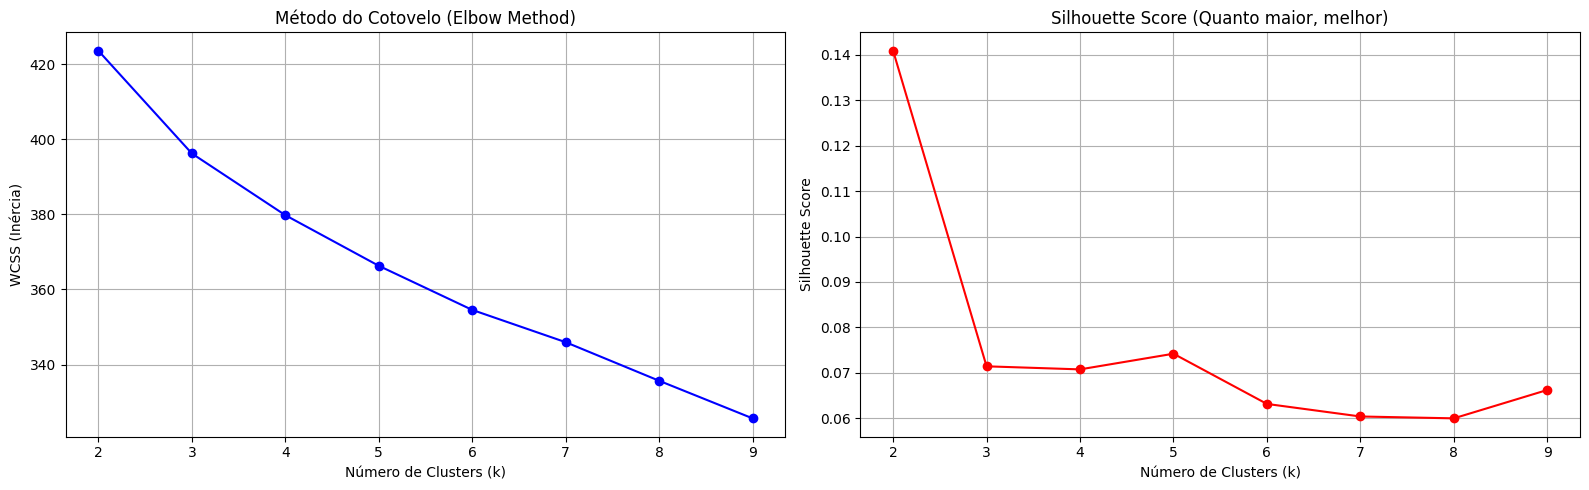

In [ ]:
# Validação do Número de Clusters (Elbow Method e Silhouette)
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

wcss = []
silhouette_scores = []
K_range = range(2, 10)

for k in K_range:
    km_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_test.fit(X_final)
    wcss.append(km_test.inertia_)
    silhouette_scores.append(silhouette_score(X_final, km_test.labels_))

fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Gráfico do Cotovelo (WCSS)
ax[0].plot(K_range, wcss, 'bo-')
ax[0].set_title('Método do Cotovelo (Elbow Method)')
ax[0].set_xlabel('Número de Clusters (k)')
ax[0].set_ylabel('WCSS (Inércia)')
ax[0].grid(True)

# Gráfico de Silhouette
ax[1].plot(K_range, silhouette_scores, 'ro-')
ax[1].set_title('Silhouette Score (Quanto maior, melhor)')
ax[1].set_xlabel('Número de Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
ax[1].grid(True)

plt.tight_layout()
plt.show()

# Visualização Espacial (PCA)

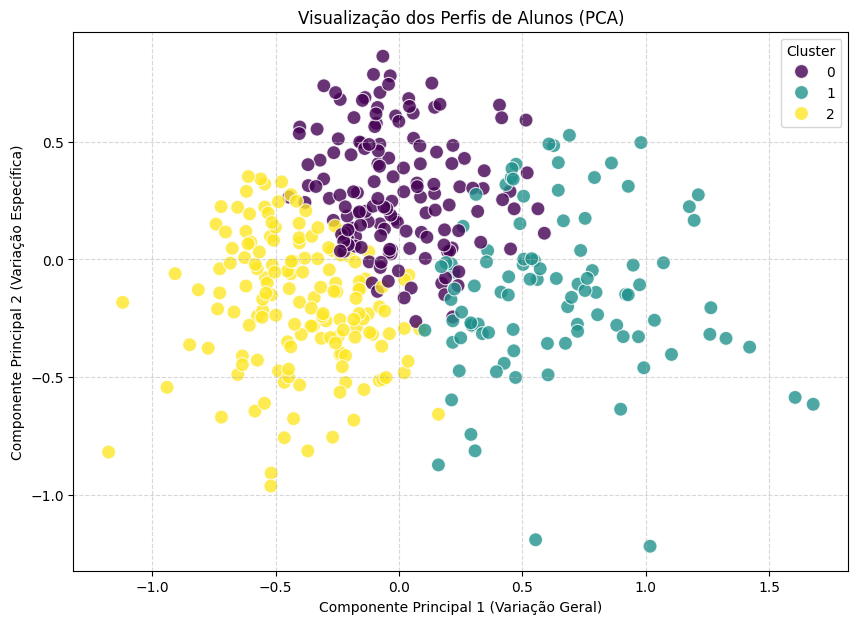

In [ ]:
# Visualização 2D dos Clusters usando PCA
from sklearn.decomposition import PCA
import seaborn as sns

# Reduzindo para 2 dimensões para poder plotar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_final)

# Criando um DataFrame temporário para o gráfico
df_pca = df_alunos.copy()
df_pca['PC1'] = X_pca[:, 0]
df_pca['PC2'] = X_pca[:, 1]

# Plotando
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='viridis', s=100, alpha=0.8)
plt.title('Visualização dos Perfis de Alunos (PCA)')
plt.xlabel('Componente Principal 1 (Variação Geral)')
plt.ylabel('Componente Principal 2 (Variação Específica)')
plt.legend(title='Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Comparação de Perfis (Gráfico de Barras)

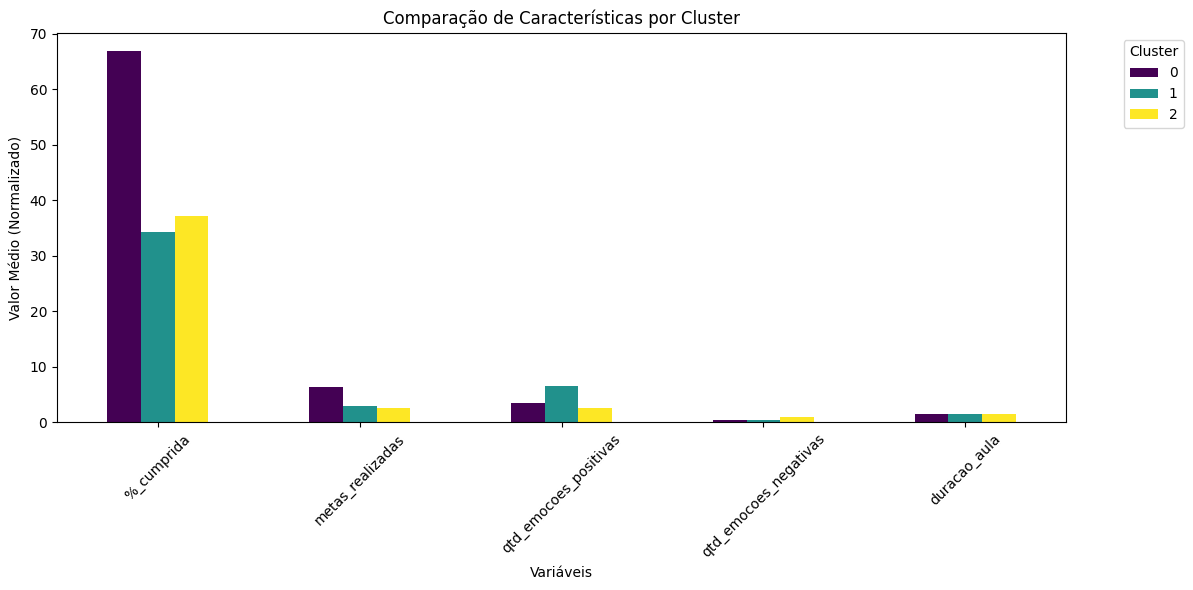

In [ ]:
# pega as médias já calculadas
perfil_medio = df_alunos.groupby('cluster')[numeric_selected_columns].mean()

# Plotando
perfil_medio.T.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.ylim(0, 100)
plt.title('Comparação de Características por Cluster')
plt.ylabel('Valor Médio (Normalizado)')
plt.xlabel('Variáveis')
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Encontrar alunos Representativos

In [44]:
# Encontrar Alunos Representativos (Arquétipos)
def get_cluster_representative_students(cluster_centers, data_matrix, student_names, n=5):
    representative_students = {}

    # Calcula a distância de TODOS os alunos para os centros dos 3 grupos
    # O resultado é uma matriz onde cada linha é um aluno e cada coluna é a distância para um cluster
    dists = euclidean_distances(data_matrix, cluster_centers)

    # Para cada cluster (0, 1, 2)
    for i in range(len(cluster_centers)):
        # Pega a coluna de distâncias referente a este cluster
        cluster_dists = dists[:, i]

        # Ordena os índices dos alunos do menor para a maior distância (argsort)
        # Pegamos os 'n' primeiros (os mais próximos do centro)
        closest_indices = np.argsort(cluster_dists)[:n]

        # Recupera os nomes usando os índices encontrados
        closest_names = student_names[closest_indices].values
        representative_students[i] = closest_names

    return representative_students

representatives = get_cluster_representative_students(kmeans.cluster_centers_, X_final, df_alunos.index, n=5)

print("-" * 60)
print("ALUNOS REPRESENTATIVOS (ARQUÉTIPOS DO GRUPO)")
print("-" * 60)
for cluster_id, names in representatives.items():
    print(f"\nCluster {cluster_id} - Alunos que melhor definem este perfil:")
    for name in names:
        print(f"  > {name}")

------------------------------------------------------------
ALUNOS REPRESENTATIVOS (ARQUÉTIPOS DO GRUPO)
------------------------------------------------------------

Cluster 0 - Alunos que melhor definem este perfil:
  > carolinna telles de assis silva
  > lara dantas cabral
  > natalia galvao paranhos de andrade
  > mariana moreira brandao
  > julia helinski

Cluster 1 - Alunos que melhor definem este perfil:
  > maria beatriz medeiros aruzo
  > valentina ramalho cunha lima
  > miguel veras alves
  > davi dickson medeiros de lima
  > gabriel machado cunha

Cluster 2 - Alunos que melhor definem este perfil:
  > yasmin verissimo lacet diniz
  > heitor jacinto marinho
  > lucas baracho pereira
  > ana maressa de andrade moreira santos
  > nicolas costa viglietti


# Dendrograma (Hierarquia)

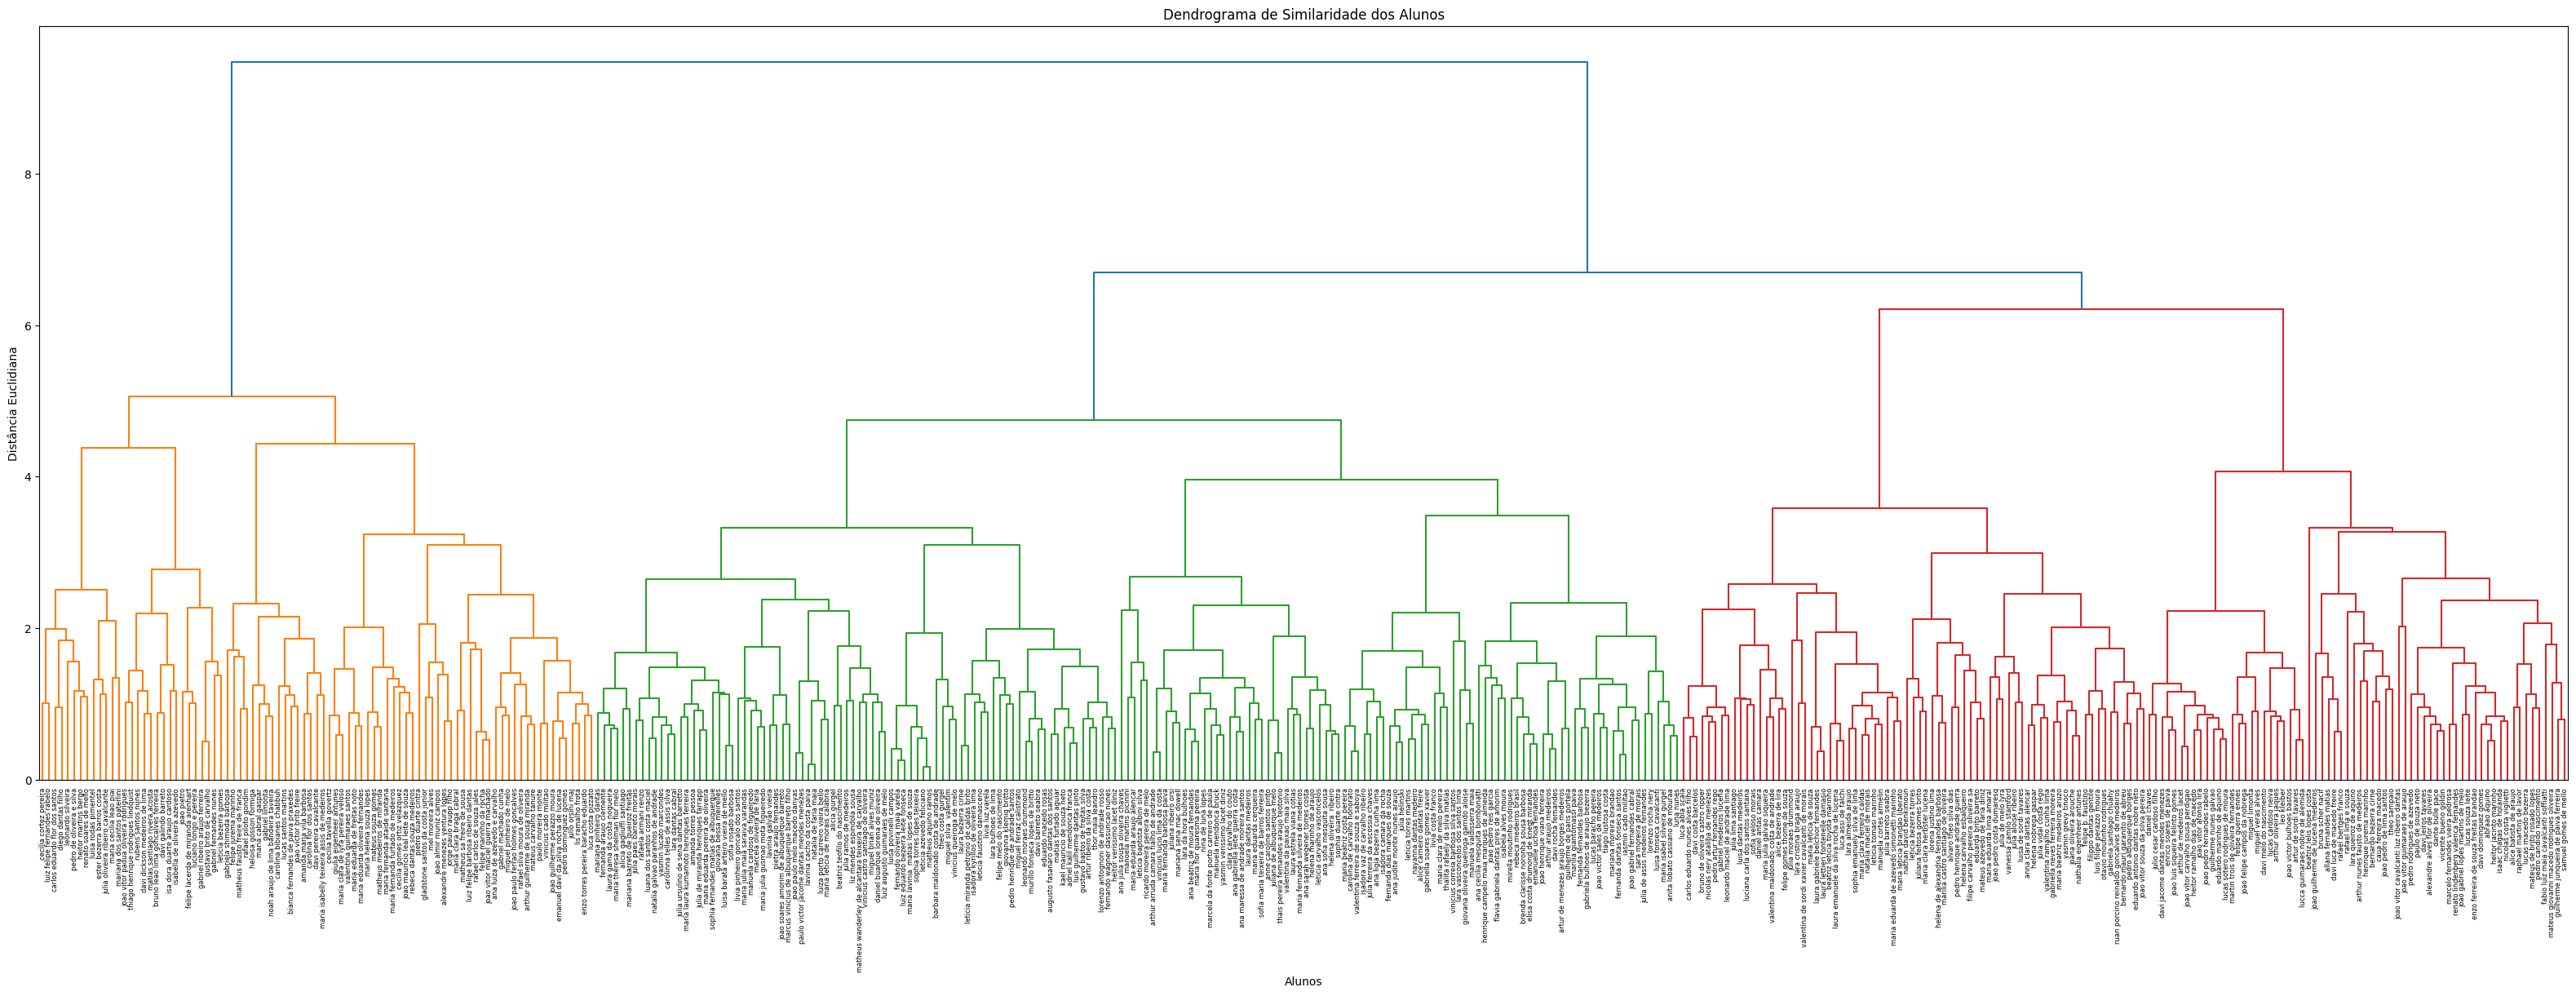

In [ ]:
# Calcular o Linkage (Matriz de ligação)
# O método 'ward' minimiza a variância dos clusters sendo fundidos (padrão do sklearn/scipy)
mergings = linkage(X_final, method='ward')

# Aumentamos a largura para 40 polegadas para tentar caber os quase 400 nomes
plt.figure(figsize=(40, 12))

# Desenhar o Dendrograma
dendrogram(mergings,
           labels=df_alunos.index,  # Nomes dos alunos no eixo X
           leaf_rotation=90,        # Rotação vertical para ler o nome
           leaf_font_size=6)        # Fonte 6 (bem pequena) para não sobrepor tudo

plt.title('Dendrograma de Similaridade dos Alunos')
plt.xlabel('Alunos')
plt.ylabel('Distância Euclidiana')
plt.margins(x=0.01) # Pequena margem lateral
plt.show()

# Clusters de perfis alunos

In [ ]:
mapa_perfis = {
    0: 'Alto Desempenho (Sucesso)',       # Maior % cumprida (66%)
    1: 'Engajado Socialmente (Atenção)',  # Muitas emoções positivas (6.47) mas baixa entrega
    2: 'Risco de Evasão (Crítico)'        # Muitas emoções negativas (0.91) e baixa entrega
}

# Criando a coluna visual no DataFrame
df_alunos['Perfil_Descritivo'] = df_alunos['cluster'].map(mapa_perfis)

print("--- Classificação Final dos Alunos ---")
print(df_alunos['Perfil_Descritivo'].value_counts())

print("\n" + "="*60)

# Mostrando 3 exemplos de cada grupo para você citar no trabalho
for perfil in df_alunos['Perfil_Descritivo'].unique():
    print(f"\n>> {perfil}:")
    display(df_alunos[df_alunos['Perfil_Descritivo'] == perfil].index[:3].tolist())

--- Classificação Final dos Alunos ---
Perfil_Descritivo
Risco de Evasão (Crítico)         151
Alto Desempenho (Sucesso)         147
Engajado Socialmente (Atenção)     98
Name: count, dtype: int64


>> Risco de Evasão (Crítico):


['abraao aquino',
 'alexandre alves flor de oliveira',
 'alice batista de araujo']


>> Alto Desempenho (Sucesso):


['adriel kalil mendonca franca',
 'alice carneiro dantas freire',
 'alicia gagliuffi santiago']


>> Engajado Socialmente (Atenção):


['alexandre menezes ventura lopes',
 'alvaro theo silva dias',
 'beatriz teofilo do nascimento']